# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 


1. Tools to find best iteration of your model
1. Visualize reward distribution on the track
 - Visualize reward heatmap per episode or iteration
1. Identify hotspots on the track for your model
1. Understand probability distributions on simulated images
1. Evaluation run analysis - plot lap speed heatmap


## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import boto3
import shutil
import os
import glob
import math
import tarfile
import requests
import json
# import sagemaker
from IPython.display import Markdown
from markdown_helper import generate_s3_write_permission_for_sagemaker_role
import glob
%matplotlib inline

In [5]:
!pip3 install shapely

You are using pip version 9.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [3]:
from log_analysis import *
from os import listdir
from os.path import isfile, join


### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [5]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Using Sagemaker IAM role arn: 
arn:aws:iam::376804254363:role/service-role/AmazonSageMaker-ExecutionRole-20200811T143087


### Permission setup for Sagemaker to S3 bucket

The sagemaker wants to download simtrace from S3 bucket. This requires PutObject permission on the bucket. Make sure the sagemaker role you are using as this permissions.

In [6]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role, "AmazonS3FullAccess")))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20200811T143087](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20200811T143087).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonS3FullAccess` policy


### Permission setup for Sagemaker to fetch appropriate DeepRacer Artifacts

The sagemaker wants to know which deepracer jobs simtrace you want to download. This requires DeepRacer service permission. Make sure the sagemaker role you are using as this permissions.

In [7]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role, "AWSDeepRacerServiceRolePolicy")))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20200811T143087](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20200811T143087).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AWSDeepRacerServiceRolePolicy` policy


## Jobs run from AWS DeepRacer Console. Download the desired log file by providing model name

If the job is run from the console (https://console.aws.amazon.com/deepracer/home?region=us-east-1#) use this else comment this out.

In [23]:
model_name="yifan-week2-model-clone2" ## Change to your model
is_training = True  ## Make this False if you want to do log analysis on Evaluation.

base_local_path = "/Users/yifanguo/Downloads"
simtrace_path = "{}/{}/sim-trace/training/training-simtrace/".format(base_local_path, model_name)
if not is_training:
    simtrace_path = "{}/{}/sim-trace/evaluation/*/evaluation-simtrace/".format(base_local_path, model_name)
merged_simtrace_path = "./logs/deepracer-{}.csv".format(model_name)

In [24]:
!rm -rf ./tmp
!rm -rf ./intermediate_checkpoint
!rm -rf ./downloaded_model

In [11]:
envroot = os.getcwd()
aws_data_path = set(os.environ.get('AWS_DATA_PATH', '').split(os.pathsep))
aws_data_path.add(os.path.join(envroot, 'models'))
os.environ.update({'AWS_DATA_PATH': os.pathsep.join(aws_data_path)})

region = "us-east-1"
dr_client = boto3.client('deepracer', region_name=region,
        endpoint_url="https://deepracer-prod.{}.amazonaws.com".format(region))
models = dr_client.list_models(ModelType="REINFORCEMENT_LEARNING",MaxResults=100)["Models"]
for model in models:
    if model["ModelName"]==model_name:
        break

NoCredentialsError: Unable to locate credentials

In [10]:
if is_training:
    training_job=dr_client.list_training_jobs(ModelArn=model["ModelArn"],MaxResults=100)["TrainingJobs"][0]
    training_log_url= dr_client.get_asset_url(Arn=training_job['JobArn'], AssetType="LOGS")['Url']

    with requests.get(training_log_url, stream=True) as response:
        with open("{}.tar.gz".format(model_name), "wb") as tarball:
            for chunk in response.iter_content(16384):
                tarball.write(chunk)
else:       
    evaluation_job = dr_client.list_evaluations(ModelArn=model["ModelArn"],MaxResults=100)["EvaluationJobs"][0]
    evaluation_log_url= dr_client.get_asset_url(Arn=evaluation_job['JobArn'], AssetType="LOGS")['Url']

    with requests.get(evaluation_log_url, stream=True) as response:
        with open("{}.tar.gz".format(model_name), "wb") as tarball:
            for chunk in response.iter_content(16384):
                tarball.write(chunk)

NameError: name 'dr_client' is not defined

In [12]:
!mkdir -p downloaded_model/{model_name}
!mkdir -p intermediate_checkpoint/{model_name}/model-artifacts

!tar -xf {model_name}.tar.gz -C ./downloaded_model/
!mkdir -p ./tmp
!rsync -a --delete --include=*.csv --exclude=* {simtrace_path} ./tmp/
!rm -rf downloaded_model/{model_name}
!rm -rf {model_name}.tar.gz

In [13]:
model_url=dr_client.get_asset_url(Arn=model["ModelArn"],AssetType="COMPLETE_MODEL_ARTIFACT")['Url']
    
with requests.get(model_url, stream=True) as response:
    with open("{}-model.tar.gz".format(model_name), "wb") as tarball:
        for chunk in response.iter_content(16384):
            tarball.write(chunk)

!tar zxvf {model_name}-model.tar.gz -C intermediate_checkpoint/ \*.csv {model_name}/model/* {model_name}/metrics/*
!rm -rf {model_name}-model.tar.gz

reInvent2019-TestModel/metrics/evaluation/evaluation-20200917040019-jfq6oEwCQvijo13i6gCR-g.json
reInvent2019-TestModel/metrics/training/training-20200903011359-uh21oZ_gTMWLlZWlhyelhA.json
reInvent2019-TestModel/model/11_Step-38428.ckpt.data-00000-of-00001
reInvent2019-TestModel/model/11_Step-38428.ckpt.index
reInvent2019-TestModel/model/11_Step-38428.ckpt.meta
reInvent2019-TestModel/model/model_10.pb
reInvent2019-TestModel/model/model_11.pb
reInvent2019-TestModel/model/model_12.pb
reInvent2019-TestModel/model/model_7.pb
reInvent2019-TestModel/model/model_metadata.json
reInvent2019-TestModel/sim-trace/evaluation/20200917040019-jfq6oEwCQvijo13i6gCR-g/evaluation-simtrace/0-iteration.csv
reInvent2019-TestModel/sim-trace/training/training-simtrace/0-iteration.csv
reInvent2019-TestModel/sim-trace/training/training-simtrace/1-iteration.csv
reInvent2019-TestModel/sim-trace/training/training-simtrace/10-iteration.csv
reInvent2019-TestModel/sim-trace/training/training-simtrace/11-iteration.csv
r

In [14]:
model_url= dr_client.get_asset_url(Arn=model["ModelArn"], AssetType="MODEL_ARTIFACT")['Url']

with requests.get(model_url, stream=True) as response:
    with open("{}-model-artifacts.tar.gz".format(model_name), "wb") as tarball:
        for chunk in response.iter_content(16384):
            tarball.write(chunk)

!tar zxvf {model_name}-model-artifacts.tar.gz -C intermediate_checkpoint/{model_name}/model-artifacts
!rm -rf {model_name}-model-artifacts.tar.gz

model_metadata.json
worker_0.multi_agent_graph_0.json
worker_0.multi_agent_graph.main_level.main_level.agent_0.csv
agent/
agent/model.pb


In [57]:
with open("{}/{}-model/model_metadata.json".format(base_local_path, model_name),"r") as jsonin:
    model_metadata=json.load(jsonin)
sensor = [sensor for sensor in model_metadata['sensor'] if sensor != "LIDAR"][0]
model_metadata

{'action_space': [{'index': 0,
   'speed': 1.1666666666666665,
   'steering_angle': -30},
  {'index': 1, 'speed': 2.333333333333333, 'steering_angle': -30},
  {'index': 2, 'speed': 3.5, 'steering_angle': -30},
  {'index': 3, 'speed': 1.1666666666666665, 'steering_angle': -15},
  {'index': 4, 'speed': 2.333333333333333, 'steering_angle': -15},
  {'index': 5, 'speed': 3.5, 'steering_angle': -15},
  {'index': 6, 'speed': 1.1666666666666665, 'steering_angle': 0},
  {'index': 7, 'speed': 2.333333333333333, 'steering_angle': 0},
  {'index': 8, 'speed': 3.5, 'steering_angle': 0},
  {'index': 9, 'speed': 1.1666666666666665, 'steering_angle': 15},
  {'index': 10, 'speed': 2.333333333333333, 'steering_angle': 15},
  {'index': 11, 'speed': 3.5, 'steering_angle': 15},
  {'index': 12, 'speed': 1.1666666666666665, 'steering_angle': 30},
  {'index': 13, 'speed': 2.333333333333333, 'steering_angle': 30},
  {'index': 14, 'speed': 3.5, 'steering_angle': 30}],
 'neural_network': 'DEEP_CONVOLUTIONAL_NETWO

## Job run from Public Notebook. Download the desired log file given the simulation ID 

#### Merge all the csv files into one big .csv file

In [25]:
def get_sort_csv_file():
    sim_trace_csvs = glob.glob("{}/{}/sim-trace/training/training-simtrace/*.csv".format(base_local_path, model_name))
    csvs_with_ids = [(int(os.path.basename(file).split("-")[0]), file) for file in sim_trace_csvs]
    csvs_sorted = sorted(csvs_with_ids, key=lambda csvs_with_ids: csvs_with_ids[0])
    return [csv_file[1] for csv_file in csvs_sorted]
    
def merge_csv_files(output_file_path):
    csv_files = get_sort_csv_file()
    header_saved = False
    with open(output_file_path, 'w') as fout:
        for csv_file in csv_files:
            with open(csv_file) as fin:
                header = next(fin)
                if not header_saved:
                    fout.write(header)
                    header_saved = True
                for line in fin:
                    fout.write(line)

merge_csv_files(merged_simtrace_path)
!tail -n 3 $merged_simtrace_path

1279,103.0,3.2640816920270286,4.705543092121824,93.1261240614524,0.0,2.333333333333333,7,0.0,False,False,63.80198867322881,42,17.671677230923088,1602082685.738865,in_progress
1279,104.0,3.2686198789748544,4.8710612720771955,90.38074252983064,-15.0,1.1666666666666665,3,0.0002,False,False,63.937149536203876,42,17.671677230923088,1602082685.8039458,in_progress
1279,105.0,3.281595549721742,4.968238968403987,87.22652517790242,0.0,1.1666666666666665,6,0.0002,True,False,63.937149536203876,42,17.671677230923088,1602082685.870019,off_track


## Load waypoints for the track you want to run analysis on


In [17]:
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
print(ListFiles)

['London_Loop_Train.npy', 'Oval_track.npy', 'July_2020.npy', 'ChampionshipCup2019_track.npy', 'LGSWide.npy', 'reInvent2019_wide.npy', 'Spain_track.npy', 'Albert.npy', 'reInvent2019_track.npy', 'New_York_Track.npy', 'AmericasGeneratedInclStart.npy', 'Belille.npy', 'reInvent2019_wide_mirrored.npy', 'Vegas_track.npy', 'AWS_track.npy', 'reinvent_base.npy', 'Bowtie_track.npy', 'Tokyo_Training_track.npy', 'H_track.npy', 'Mexico_track.npy', 'Virtual_May19_Train_track.npy', 'China_track.npy', 'Canada_Training.npy', 'FS_June2020.npy', 'Straight_track.npy']


In [5]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)

# if is_training:
#     track_arn=training_job["Config"]["TrackConfig"]["TrackArn"]
# else:
#     track_arn=evaluation_job["Config"]["TrackArn"]

trackname="reinvent_base"
waypoints = get_track_waypoints(trackname) ### re:invent track
waypoints.shape

(71, 6)

## Visualize the Track and Waypoints

In [6]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

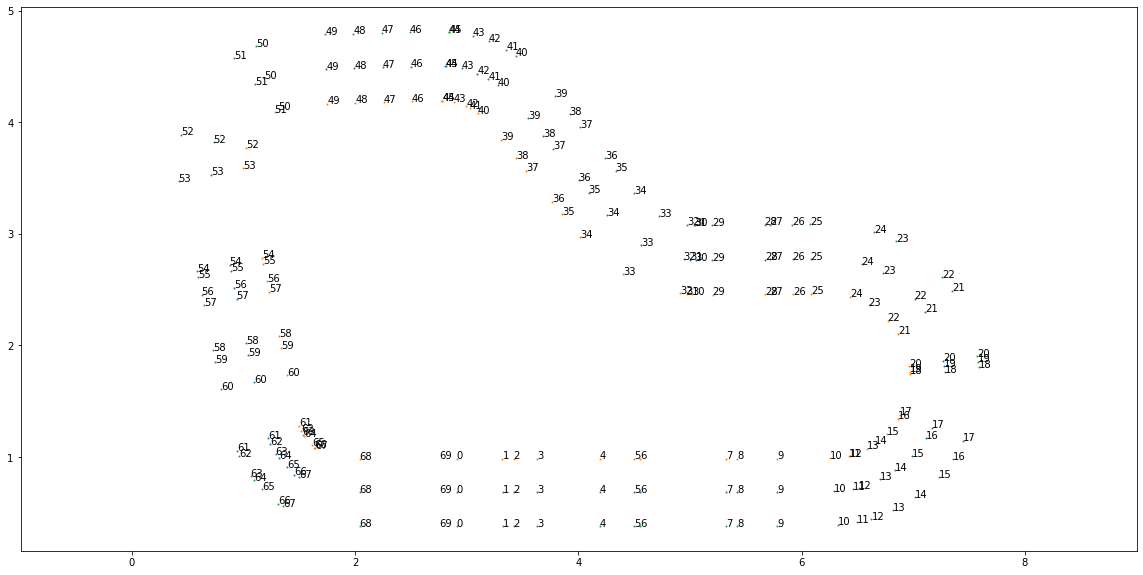

In [7]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

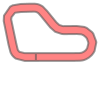

In [8]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [9]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# Helper Functions 

In [10]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0, scale=100):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    #track = np.zeros(track_size) # lets magnify the track by *100
    #for index, row in df.iterrows():
    #    x = int(row["x"]*scale + x_offset)
    #    y = int(row["y"]*scale + y_offset)
    #    reward = row["reward"]
    #    track[y, x] = reward
        #plt.plot(y,x,reward)
    allx=[]
    ally=[]
    allreward=[]
    for index, row in df.iterrows():
        x = float(row["x"])
        y = float(row["y"])
        reward = float(row["reward"])
        allx.append(x)
        ally.append(y)
        allrewards=reward
        #track[y, x] = reward
        #plt.plot(y,x,reward)
    heatmap, xedges, yedges = np.histogram2d(allx, ally, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return heatmap.T,extent

In [11]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
        
    return fig

## Load the training log

In [12]:
EPISODE_PER_ITER = 20 if is_training else 1

In [26]:
df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(df.episode.max()/EPISODE_PER_ITER)+1) * EPISODE_PER_ITER
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
df.head()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,iteration
0,0,1.0,3.049558,0.683396,0.166751,-30.0,2.333333,1,0.0,False,True,0.789755,0,17.671677,1.602076e+09,in_progress,1
1,0,2.0,3.051331,0.682674,-0.022232,30.0,2.333333,13,0.7,False,True,0.799787,0,17.671677,1.602076e+09,in_progress,1
2,0,3.0,3.057252,0.677297,-1.513441,-15.0,1.166667,3,0.2,False,True,0.833281,0,17.671677,1.602076e+09,in_progress,1
3,0,4.0,3.064020,0.670956,-3.170487,-30.0,1.166667,0,0.2,False,True,0.871564,0,17.671677,1.602076e+09,in_progress,1
4,0,5.0,3.073273,0.654027,-7.352447,-15.0,2.333333,4,0.0,False,True,0.923894,0,17.671677,1.602076e+09,in_progress,1


In [28]:
df['y'].min(), df['x'].max()

(0.06132005554960575, 7.912317422959875)

In [29]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())


In [16]:
df['reward'].min(), df['reward'].max()

(0.0, 1.0)

## Plot rewards per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

Number of episodes =  1279


Text(0.5, 0, 'Episode')

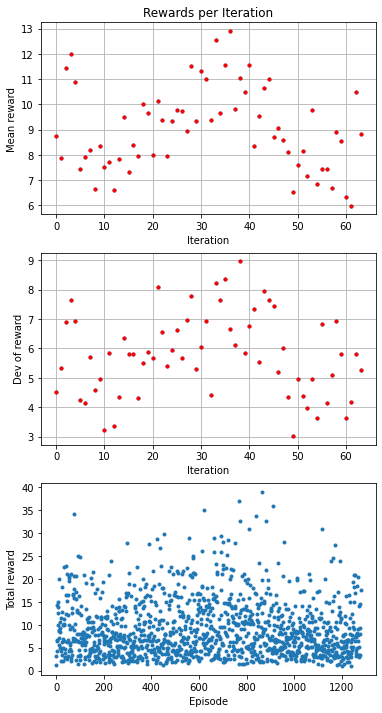

In [30]:
REWARD_THRESHOLD = 0

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes+1):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == EPISODE_PER_ITER:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

## Analyze training/evaluation metrics with progress and reward function

This graph gives you an idea whether your model has convergered or more training is required. If you see the curve trending upwards then more training time would help the agent to get better rewards

In [31]:
if is_training:
    METRIC_PATH = glob.glob("{}/{}/metrics/training/*.json".format(base_local_path, model_name))[0]
else:
    METRIC_PATH = glob.glob("{}/{}/metrics/evaluation/*.json".format(base_local_path, model_name))[0]
    
with open(METRIC_PATH, "r") as fp:
    data = json.loads(fp.read())
    metric_data = data['metrics']
    df_metrics = pd.DataFrame(metric_data)

if is_training:
    df_metrics = df_metrics[df_metrics['phase'] == "training"]

In [32]:
df_metrics

,reward_score,episode,metric_time,phase,elapsed_time_in_milliseconds,episode_status,completion_percentage,trial,start_time
0,2,1,24625,training,966,Off track,1,1,23659
1,5,2,27288,training,2262,Off track,16,2,25026
2,21,3,31226,training,3641,Off track,26,3,27585
3,6,4,32698,training,1160,Off track,7,4,31538
4,10,5,35165,training,2107,Off track,13,5,33058
...,...,...,...,...,...,...,...,...,...
1805,8,1293,6990691,training,1503,Off track,12,13,6989188
1806,14,1294,6993290,training,2185,Off track,18,14,6991105
1807,17,1295,6996090,training,2448,Off track,23,15,6993642
1808,19,1296,6998421,training,2004,Off track,14,16,6996417


Mean percentage: 18.977640709329222


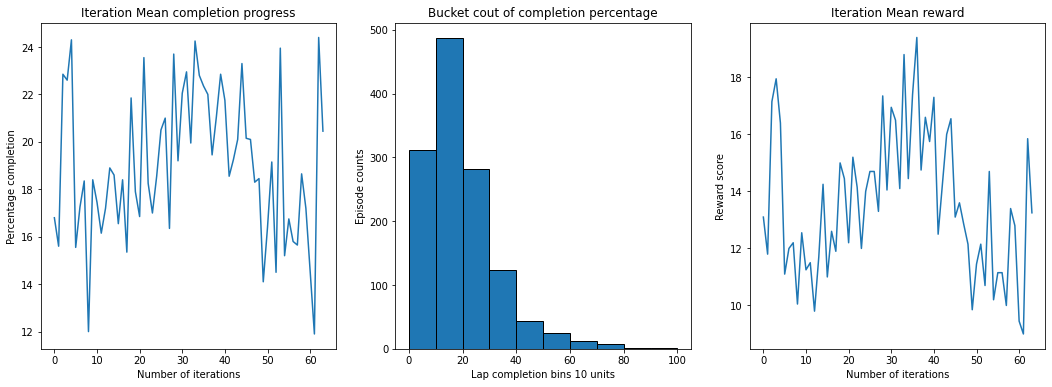

In [33]:
bins= [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

df_metrics = df_metrics.sort_values(by="metric_time")
print('Mean percentage: {}'.format(df_metrics.completion_percentage.mean()))

completion_percentage_np = np.array(df_metrics.completion_percentage)
episode_progress_buckets = np.split(completion_percentage_np[:EPISODE_PER_ITER*(len(completion_percentage_np)//EPISODE_PER_ITER)],
                                    len(completion_percentage_np)//EPISODE_PER_ITER)
episode_progress_mean = np.mean(episode_progress_buckets, axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Line graph showing the mean iteration of completion progress
ax1.plot(episode_progress_mean)
ax1.title.set_text('Iteration Mean completion progress')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Percentage completion')

# Bar chart to show completion_percentage with bucketing of 10% bar chart
ax2.hist(df_metrics.completion_percentage, bins=bins, edgecolor="k")
ax2.title.set_text('Bucket cout of completion percentage')
ax2.set_xlabel('Lap completion bins 10 units')
ax2.set_ylabel('Episode counts')

# Line graph showing the mean iteration of reward mean
if is_training:
    reward_score_np = np.array(df_metrics.reward_score)
    episode_reward_buckets = np.split(reward_score_np[:EPISODE_PER_ITER*(len(reward_score_np)//EPISODE_PER_ITER)],
                                                      len(reward_score_np)//EPISODE_PER_ITER)
    episode_reward_mean = np.mean(episode_reward_buckets, axis=1)
    ax3.plot(episode_reward_mean)
    plt.title("Metric analysis - Reward/percentage vs number of iterations")
    ax3.title.set_text('Iteration Mean reward')
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Reward score')
    plt.show()


## Analyze the reward distribution for your reward function

In [34]:
print("Min x-axis {}; Max x-axis {}".format(np.min(df['x']), np.max(df['x'])))
print("Min y-axis {}; Max y-axis {}".format(np.min(df['y']), np.max(df['y'])))

Min x-axis 0.1278472243911132; Max x-axis 7.912317422959875
Min y-axis 0.06132005554960575; Max y-axis 5.143432207443776


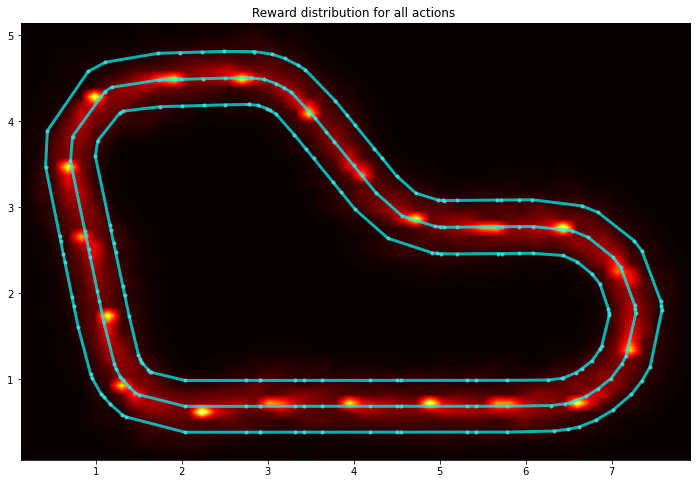

In [40]:
track,extent = plot_track(df, track_size=(10, 10), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Plot a particular iteration


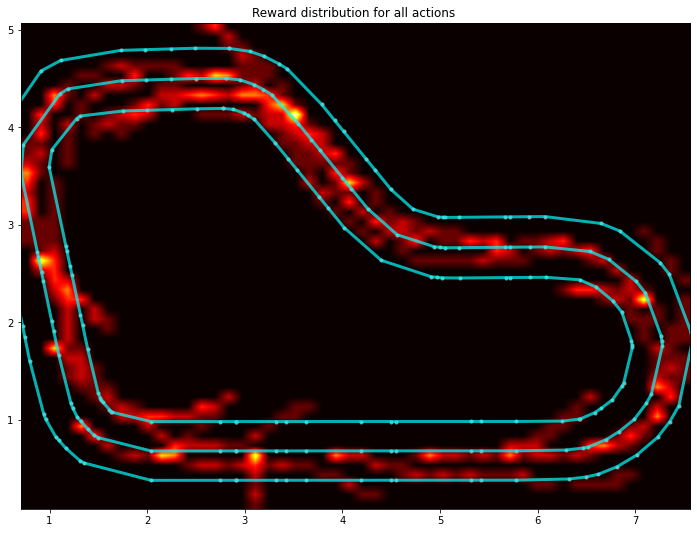

In [44]:
iteration_id = 1
track,extent = plot_track(df[df['iteration'] == iteration_id], track_size=(10, 10), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

The top 3 highest reward episodes are [864, 768, 911]


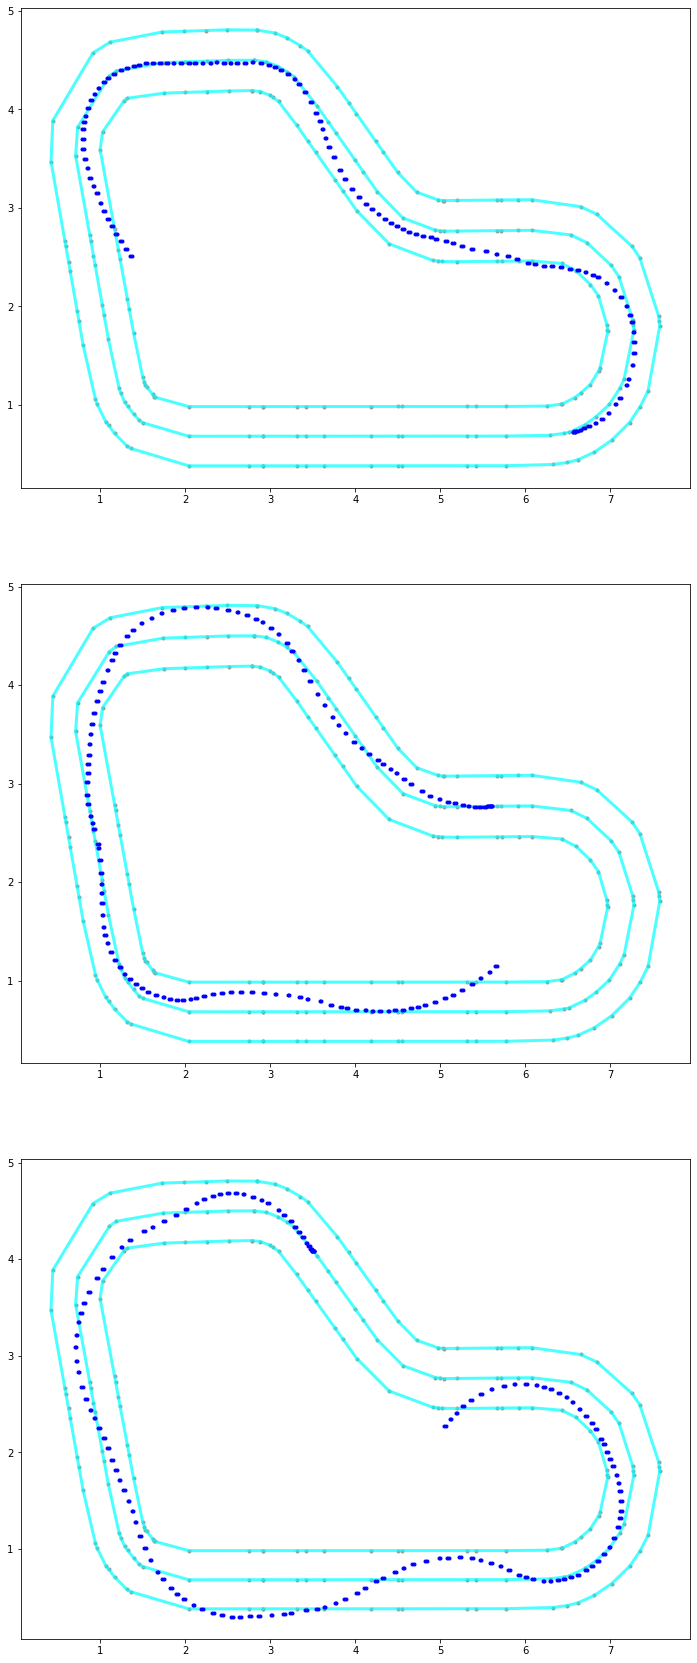

In [45]:
action_map, episode_map, sorted_idx = episode_parser(df)    
fig = plot_top_laps(sorted_idx[:], 3)
print("The top 3 highest reward episodes are {}".format(sorted_idx[:3]))

### Path taken in a particular episode

In [46]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

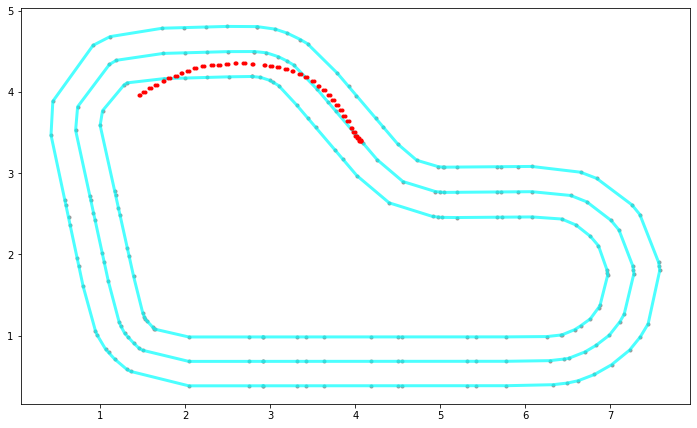

In [54]:
plot_episode_run(df, E=10) # arbitrary episode

### Path taken in a particular Iteration

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

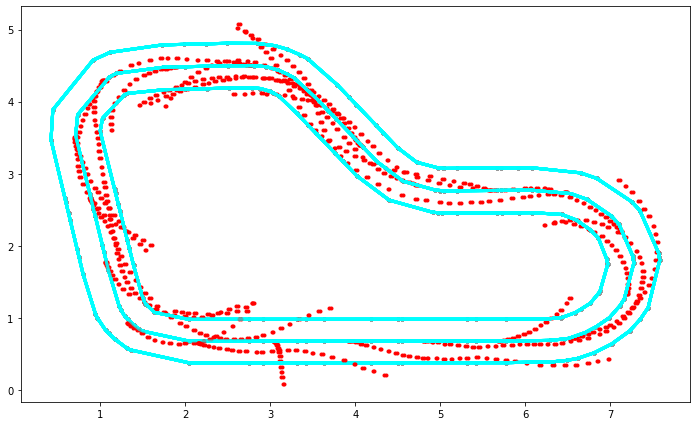

In [55]:
iteration_id = 1

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, E=i)

## Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration.

Say you want the car to go at higher speeds on the straight line. This will give you an idea what actions the car is taking along those segments

In [58]:
# The actions plotted on the tracks may become noise. Use this to clip the low reward values action.
# Anything with reward < 0.8 is clipped. This is based on the reward function you trained on.

REWARD_THRESHOLD = 0.8

In [59]:
# Track Segment Labels
action_names = []
for action in model_metadata['action_space']:
    action_names.append("ST"+str(action['steering_angle'])+" SP"+"%.2f"%action["speed"])
action_names

['ST-30 SP1.17',
 'ST-30 SP2.33',
 'ST-30 SP3.50',
 'ST-15 SP1.17',
 'ST-15 SP2.33',
 'ST-15 SP3.50',
 'ST0 SP1.17',
 'ST0 SP2.33',
 'ST0 SP3.50',
 'ST15 SP1.17',
 'ST15 SP2.33',
 'ST15 SP3.50',
 'ST30 SP1.17',
 'ST30 SP2.33',
 'ST30 SP3.50']

i = 0, len = 12
i = 2, len = 12
i = 4, len = 12
i = 6, len = 12
i = 8, len = 12
i = 10, len = 12
Number of steps in iteration= 677


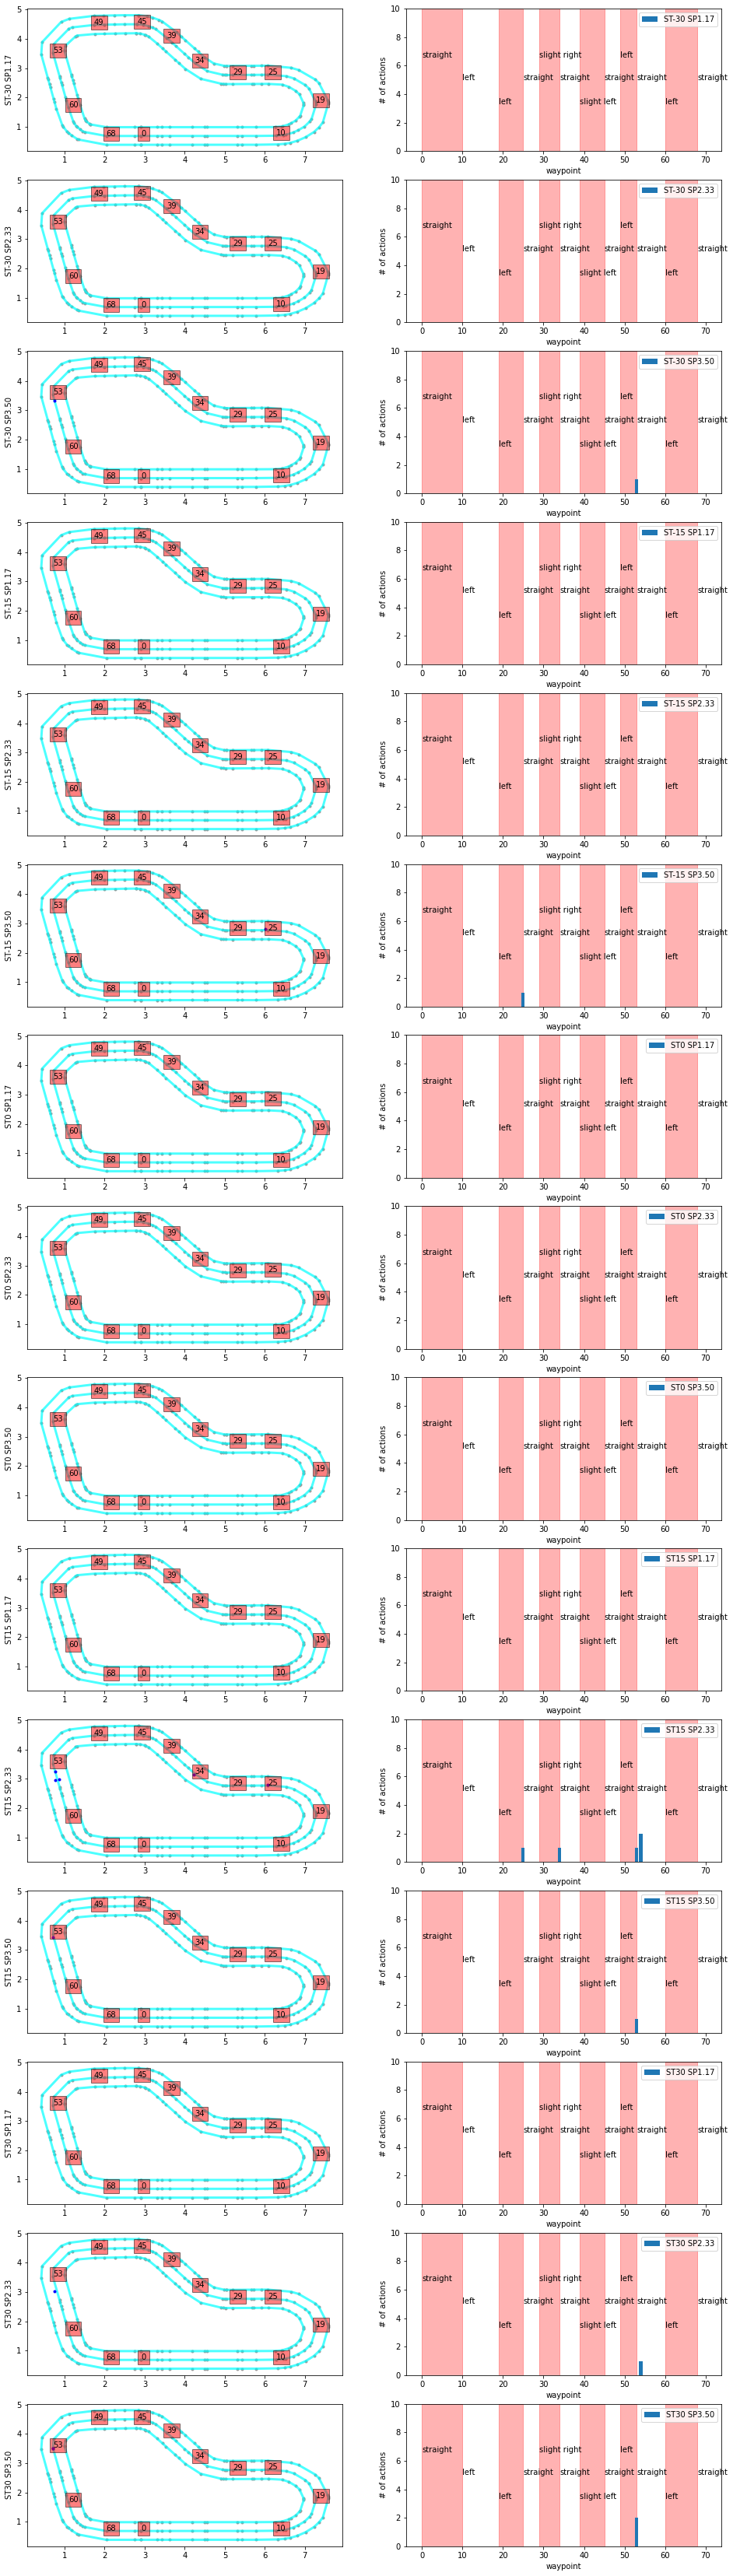

In [75]:
fig = plt.figure(figsize=(16, 4*len(action_names)))
iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

#action_names = ['LEFT', 'RIGHT', 'STRAIGHT', 'SLIGHT LEFT', 'SLIGHT RIGHT', 'SLOW']
vert_lines = [0,10,19,25,29,34,39,45,49,53,60,68]
y_limit = 10
track_segments = [(0, .66*y_limit, 'straight'),
                  (10, .5*y_limit, 'left'),
                  (19, .33*y_limit, 'left'),
                  (25, .5*y_limit, 'straight'),
                  (29, .66*y_limit, 'slight right'),
                  (34, .5*y_limit, 'straight'),
                  (39, .33*y_limit, 'slight left'),
                  (45, .5*y_limit, 'straight'),
                  (49, .66*y_limit, 'left'),
                  (53, .5*y_limit, 'straight'),
                  (60, .33*y_limit, 'left'),
                  (68, .5*y_limit, 'straight')
                 ]
segment_x=[]
segment_y=[]
segment_xerr_l=[]
segment_xerr_r=[]
segment_yerr_n=[]
segment_yerr_s=[]
i=0
while i<len(vert_lines):
    segment_x.append(vert_lines[i])
    segment_y.append(0)
    segment_xerr_l.append(0)
    print("i = {}, len = {}".format(i, len(vert_lines)))
    if i>len(vert_lines)-1:
        segment_xerr_r.append(len(waypoints)-vert_lines[i])
    else:
        segment_xerr_r.append(vert_lines[i+1]-vert_lines[i])
    segment_yerr_n.append(0)
    segment_yerr_s.append(y_limit)
    i+=2

segment_x = np.array(segment_x)
segment_y = np.array(segment_y)
segment_xerr = np.array([segment_xerr_l,segment_xerr_r])
segment_yerr = np.array([segment_yerr_n,segment_yerr_s])

#segment_x = np.array(vert_lines)
#segment_y = np.array([0]*len(vert_lines))
#segment_xerr = np.array([[0]*len(vert_lines),[1]*len(vert_lines)])
#segment_yerr = np.array([[0]*len(vert_lines), [150]*len(vert_lines)])

wpts_array = center_line 

for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration=', n_steps_in_iter)

    # Reward function threshold
    th = REWARD_THRESHOLD
    for idx in range(len(action_names)):
        ax = fig.add_subplot(len(action_names), 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'b.')

        for idWp in vert_lines:
            ax.text(wpts_array[idWp][0], wpts_array[idWp][1], str(idWp), bbox=dict(facecolor='red', alpha=0.5))

        #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        for idWp in range(len(wpts_array)):
            action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

        ax = fig.add_subplot(len(action_names), 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)

        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], track_segments[tt][1], track_segments[tt][2])

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, y_limit))

Lets analyze the hairpin turn for the best iteration. We see that the model like to take Slight left and Straight over other actions, we see that slight right and right actions frequency is very low in comparison. In short, this model seems to do well for the hairpin turn 

## Simulation Image Analysis - Probability distribution on decisions (actions)

is the model making decisions that are "too close" or is it confident for the laps it finishes. if the top and second best decisions are far apart, the model must likely be making more confident decisions 

In [44]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

#### Download all the checkpoints (provided as an example).  
We recommend downloading only the ones you are interested in


In [77]:
!pip3 install tensorflow

    100% |████████████████████████████████| 165.1MB 6.4kB/s ta 0:00:011 4% |█▍                              | 7.2MB 11.7MB/s eta 0:00:14    16% |█████▎                          | 27.1MB 10.6MB/s eta 0:00:13    25% |████████                        | 41.3MB 3.5MB/s eta 0:00:36    26% |████████▍                       | 43.5MB 11.0MB/s eta 0:00:12    27% |████████▉                       | 45.5MB 8.4MB/s eta 0:00:15    32% |██████████▎                     | 53.1MB 7.0MB/s eta 0:00:16    46% |███████████████                 | 77.5MB 4.0MB/s eta 0:00:22    52% |█████████████████               | 87.1MB 7.1MB/s eta 0:00:11    64% |████████████████████▌           | 105.9MB 8.0MB/s eta 0:00:08    66% |█████████████████████▍          | 110.5MB 8.9MB/s eta 0:00:07    71% |███████████████████████         | 118.5MB 7.9MB/s eta 0:00:06    81% |██████████████████████████      | 134.1MB 7.3MB/s eta 0:00:05    95% |██████████████████████████████▌ | 157.5MB 8.7MB/s eta 0:00:01    98% |████████████████████

    100% |████████████████████████████████| 81kB 1.2MB/s ta 0:00:01
    100% |████████████████████████████████| 153kB 2.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for wrapt ... done
  Stored in directory: /Users/yifanguo/Library/Caches/pip/wheels/b1/c2/ed/d62208260edbd3fa7156545c00ef966f45f2063d0a84f8208a
Successfully built wrapt
  Found existing installation: six 1.11.0
    Uninstalling six-1.11.0:
      Successfully uninstalled six-1.11.0
  Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Found existing installation: setuptools 39.1.0
    Uninstalling setuptools-39.1.0:
      Successfully uninstalled setuptools-39.1.0
  Found existing installation: absl-py 0.2.0
    Uninstalling absl-py-0.2.0:
      Successfully uninstalled absl-py-0.2.0
  Found existing installation: protobuf 3.5.2.post1
    Uninstalling protobuf-3.5.2.post1:
      Successfully uninstalled protobuf-3.5.2.post1
  Found existing installation: t

In [78]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image

GRAPH_PB_PATH = 'intermediate_checkpoint/'

def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)
    
    # For front cameras/stereo camera use the below
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

ImportError: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: dlopen(/usr/local/lib/python3.6/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so, 6): Symbol not found: _SecKeyCopyExternalRepresentation
  Referenced from: /usr/local/lib/python3.6/site-packages/tensorflow/python/../libtensorflow_framework.2.dylib
  Expected in: /System/Library/Frameworks/Security.framework/Versions/A/Security
 in /usr/local/lib/python3.6/site-packages/tensorflow/python/../libtensorflow_framework.2.dylib


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [46]:
model_inference = []
iterations = [7,8,9]
models_file_path = glob.glob("{}/{}-model/agent/model*.pb".format(base_local_path, model_name))

for model_file in models_file_path:
    model, obs, model_out = load_session(model_file)
    arr = []
    for f in all_files[:]:
        img = Image.open(f)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
        arr.append (y_output)
        
    model_inference.append(arr)
    model.close()
    tf.reset_default_graph()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: intermediate_checkpoint/reInvent2019-TestModel/model/model_12.pb
Instructions for updating:
Use tf.gfile.GFile.
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: intermediate_checkpoint/reInvent2019-TestModel/model/model_11.pb
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: intermediate_checkpoint/reInvent2019-TestModel/model/model_10.pb
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: intermediate_checkpoint/reInvent2019-TestModel/model/model_7.pb


In [79]:
prob_diff = []
models_file_path = glob.glob("{}/{}-model/agent/model*.pb".format(base_local_path, model_name))
for model, model_file in zip(model_inference, models_file_path):
    print("Inference for model: {}".format(model_file))
    for mi in model:
        max1, max2 = mi.argsort()[-2:][::-1]
        prob_diff.append(mi[max1] - mi[max2])
    plt.hist(prob_diff)
    plt.show()

NameError: name 'model_inference' is not defined

The model which appears to have a better seperation in probabability will work better in sim2real experiments

# Model CSV Analysis


Download the model from the console AWS DeepRacer > Reinforcement learning > $Training Job Name$ > Download Model


In [48]:
fname = '{}/{}/model-artifacts/worker_0.multi_agent_graph.main_level.main_level.agent_0.csv'.format(base_local_path, model_name)
df_csv = pd.read_csv(fname)

In [49]:
df_csv.columns

Index(['Episode #', 'Training Iter', 'Epoch', 'In Heatup', 'ER #Transitions',
       'ER #Episodes', 'Episode Length', 'Total steps', 'Epsilon',
       'Shaped Training Reward', 'Training Reward', 'Update Target Network',
       'Wall-Clock Time', 'Evaluation Reward', 'Shaped Evaluation Reward',
       'Success Rate', 'Inverse Propensity Score', 'Direct Method Reward',
       'Doubly Robust', 'Weighted Importance Sampling',
       'Sequential Doubly Robust', 'Loss/Mean', 'Loss/Stdev', 'Loss/Max',
       'Loss/Min', 'Learning Rate/Mean', 'Learning Rate/Stdev',
       'Learning Rate/Max', 'Learning Rate/Min', 'Grads (unclipped)/Mean',
       'Grads (unclipped)/Stdev', 'Grads (unclipped)/Max',
       'Grads (unclipped)/Min', 'Discounted Return/Mean',
       'Discounted Return/Stdev', 'Discounted Return/Max',
       'Discounted Return/Min', 'Entropy/Mean', 'Entropy/Stdev', 'Entropy/Max',
       'Entropy/Min', 'Advantages/Mean', 'Advantages/Stdev', 'Advantages/Max',
       'Advantages/Min',

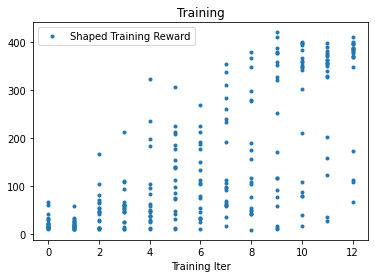

In [50]:
title = "Training"
df_csv.plot(x='Training Iter', y='Shaped Training Reward', style='.', 
        title=title)

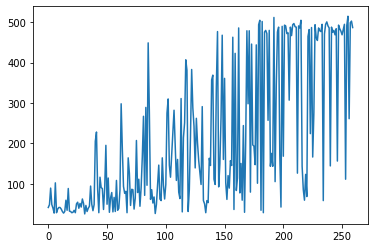

In [51]:
df_csv['Episode Length'].plot()

## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

In [52]:
import cv2
import numpy as np
import tensorflow as tf

def visualize_gradcam_discrete_ppo(sess, rgb_img, category_index=0, num_of_actions=5):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    
    # For front cameras use the below
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/{}/Conv2d_4/Conv2D:0'.format(sensor))
    
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

In [53]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

In [54]:
model_path = models_file_path[0] #Change this to your model 'pb' frozen graph file

model, obs, model_out = load_session(model_path)
heatmaps = []
for f in all_files[:5]:
    img = np.array(Image.open(f))
    heatmap = visualize_gradcam_discrete_ppo(model, img, category_index=0, num_of_actions=len(action_names))
    heatmaps.append(heatmap)
tf.reset_default_graph()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: intermediate_checkpoint/reInvent2019-TestModel/model/model_12.pb


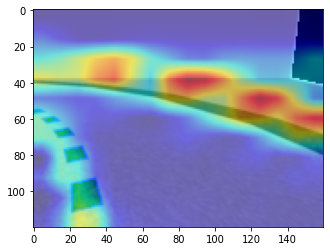

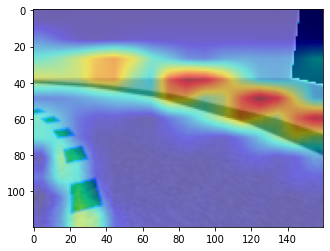

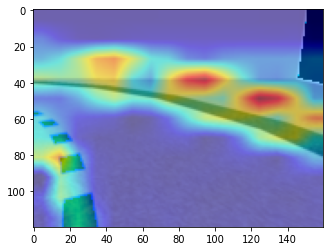

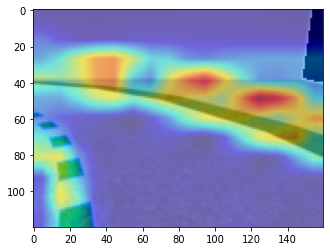

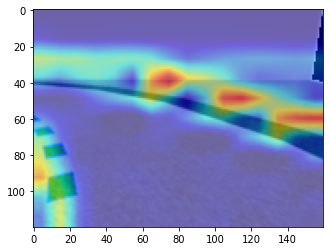

In [55]:
for i in range(len(heatmaps)):
    plt.imshow(heatmaps[i])
    plt.show()